In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
from pathlib import Path
import json
from glob import glob

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

SCRIPT_PATH = Path('/content/drive/MyDrive/Colab Notebooks/CycleGAN')
EXPERIMENT_ID = 'EXP_1'
MODEL_SAVE_PATH1 = SCRIPT_PATH / EXPERIMENT_ID / 'G_A2B'
MODEL_SAVE_PATH2 = SCRIPT_PATH / EXPERIMENT_ID / 'G_B2A'

DEFAULT_TFRECORDS_PATH = SCRIPT_PATH / 'tfrecords-output'
try:
    json_file = DEFAULT_TFRECORDS_PATH / 'dataset.json'
    with json_file.open('r') as f:
        json_dict = json.load(f)
    NUM_INPUT_A_DATA = json_dict['num_testA_images']
    NUM_INPUT_B_DATA = json_dict['num_testB_images']
except: 
    print("The number of test data is unknown.")
    sys.exit()
    
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
def _parse_function(example):
    features = tf.io.parse_single_example(
        example,
        features={
            'filename': tf.io.FixedLenFeature([], tf.string, default_value = ''),
            'image/encoded': tf.io.FixedLenFeature([], tf.string,
                                                default_value=''),
        })
    image_encoded = features['image/encoded']

    return image_encoded

In [3]:
def decode_jpg(image_encoded):

    # Decode the JPEG.
    image = tf.io.decode_jpeg(image_encoded, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image = tf.image.random_flip_left_right(image)
    image = image*2.-1.

    return image

In [9]:
testA_data_files = tf.data.Dataset.list_files(glob(str(DEFAULT_TFRECORDS_PATH / 'testA-*')))
testA_dataset = tf.data.TFRecordDataset(testA_data_files, num_parallel_reads=AUTOTUNE) \
        .map(_parse_function, num_parallel_calls=AUTOTUNE) \
        .map(decode_jpg, num_parallel_calls=AUTOTUNE) \
        .shuffle(NUM_INPUT_A_DATA) 

In [10]:
testB_data_files = tf.data.Dataset.list_files(glob(str(DEFAULT_TFRECORDS_PATH / 'testB-*')))
testB_dataset = tf.data.TFRecordDataset(testB_data_files, num_parallel_reads=AUTOTUNE) \
        .map(_parse_function, num_parallel_calls=AUTOTUNE) \
        .map(decode_jpg, num_parallel_calls=AUTOTUNE) \
        .shuffle(NUM_INPUT_B_DATA) 

In [11]:
A_B_dataset = tf.data.Dataset.zip((testA_dataset, testB_dataset))

In [13]:
G_A2B = tf.saved_model.load(str(MODEL_SAVE_PATH1))
G_B2A = tf.saved_model.load(str(MODEL_SAVE_PATH2))

In [14]:
images_title = ['A', 'A2B', 'A2B2A', 'B', 'B2A', 'B2A2B']

def generate_and_save_images(A, B):

    A = A[np.newaxis, :]
    B = B[np.newaxis, :]

    A2B = G_A2B(A, training=False)
    B2A = G_B2A(B, training=False)
    A2B2A = G_B2A(A2B, training=False)
    B2A2B = G_A2B(B2A, training=False)

    images = [A, A2B, A2B2A, B, B2A, B2A2B]

    plt.figure(figsize=(8, 6))

    for i in range(6):
        image = images[i]
        image = image[0]
        image = (image+1.)/2.

        title_name = images_title[i]

        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(title_name)

    plt.tight_layout() 
    plt.show()

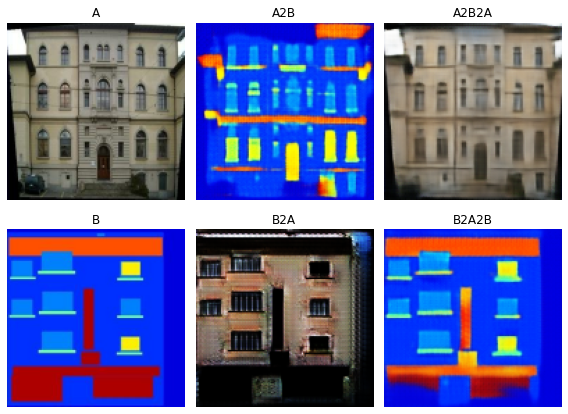

In [22]:
for image_A, image_B in A_B_dataset.take(1):
    generate_and_save_images(image_A, image_B)